<a href="https://colab.research.google.com/github/AishaEvering/PyTorch_Exercises/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Milestone Project 2: 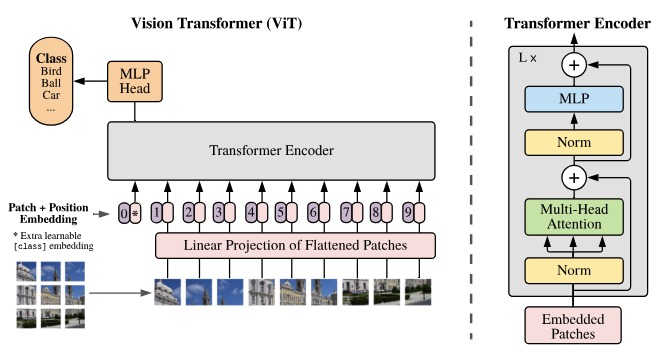PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch.  

Paper: https://arxiv.org/abs/2010.11929

See ground truth notebook here: https://www.learnpytorch.io/08_pytorch_paper_replicating/

## 0. Get setup

Let's import code we've previously written + required libraries.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 34.35 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

The whole goal of what we're trying to do is to replicate teh ViT architecture for our FoodVission Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# Create image size
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up later.)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto. *visualize, visualize, visualize*

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

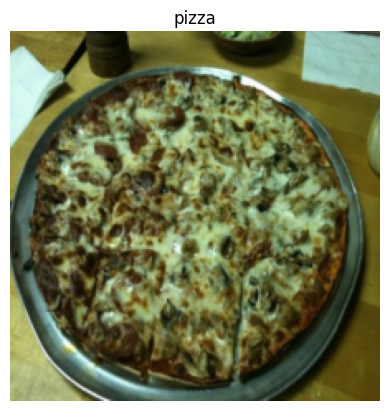

In [9]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whold machine learning research paper can be intimidating

So in order to make it more understandable, we can break it down into smaller pieces.

* **Inputes** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model** (or architecture) - A collection of blocks.


### 3.1 Vit Overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the funcitons of each layer/block
* Table 1/3: different hyperpatameters for the architecture/training.
* Text

### Figure 1
<img src= "https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/Vit_Arch.png?raw=true" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve them over time)

### Four equations
<img src = "https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/ViT-Four-Equations.png?raw=true" width=600 alt="four equations from vision transformer paper"/>

Section 3.1:

3.1 VISION TRANSFORMER (VIT)

**Equation 1:** An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.
<br/><br/>
**Equation 1:** Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudo code:

```python
# Equation 1
# pos = position

linear_embed = [class_token, image_patch1, image_patch_2, ..., image_patch_N]
pos_embed = [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
x_input = linear_embed + pos_embed
```

----

Equations 2&3: The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudo code
```python
# Equation 2
# MSA = Multi-head self attention
# LN = Layer Norm which is the normilization layer
# ...+x_input is the residual connection or the skip connection

x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input


# Equation 3
# MLP = Multilayer Perceptrons = a neural network with X number of layers
# ...+x_output_MSA_block is the residual connection or the skip connection
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
---

**Equation 4:** Similar to BERT's [class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudo code
```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

---


### Table 1
<img src= "https://github.com/AishaEvering/PyTorch_Exercises/blob/main/assests/ViT-Hyperpameters.png?raw=true" width=600 alt="tabel 1 from vision transformer paper that contains the hyperparameters"/>

* ViT-Base, ViT-Large, and ViT-Huge are all different sizes of the same model architecture.
* ViT-B/16 = ViT-Base with image patch size 16x16
* Layers = the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture.  For example the input of patches will turn into a vector of size 768 for ViT-Base.
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention

### 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers - input -> function -> output

What's the input shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)

What's the output shape?

* Output shape: ???

### 4.1 Calculate input and output shape by hand

>**Equation 1:** An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.
<br/><br/>
>**Equation 1:** Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* H = height
* W = width
* C = color channels
* P = patch size
* D = constant latent vector size = embedding dimension (see Table 1)

* Input shape: ${H}\times{W}\times{C}$
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* N = number of patches = $({H}\times{W}) / P^{2}$



In [10]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [11]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches:): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches:): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Turning as single image into patches

Let's *visualize, visualize, visualize!*

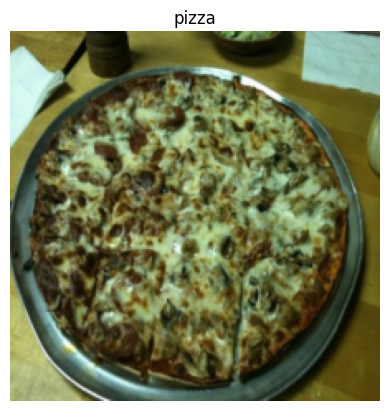

In [12]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [13]:
image.shape

torch.Size([3, 224, 224])

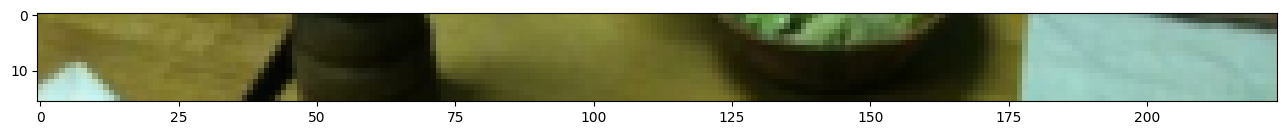

In [14]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0 
Number of patches per column: 14.0 
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


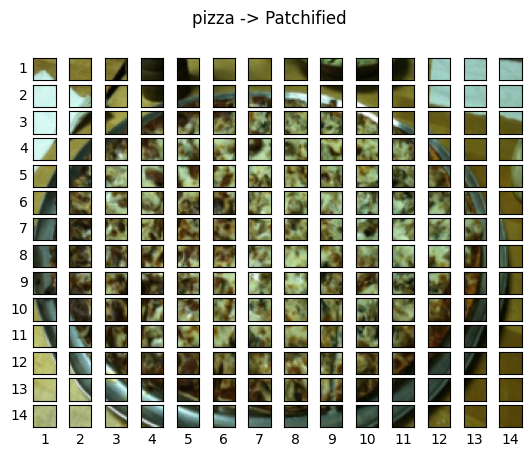

In [15]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches} \
\nNumber of patches per column: {num_patches} \
\nTotal patches: {num_patches*num_patches}\
\nPatch size: {patch_size} pixels x {patch_size} pixels")

def plot_patches(image: torch.Tensor, img_size: int, patch_size: int) -> None:
  # Create a series of subplots
  fig, ax = plt.subplots(nrows = img_size // patch_size,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey = True)

  # Iterate through number of rows
  for r, row_patch in enumerate(range(0, img_size, patch_size)):
    # Iterate through number of patches in the top row
    for c, col_patch in enumerate(range(0, img_size, patch_size)):
      ax[r, c].imshow(image[row_patch:row_patch+patch_size, col_patch:col_patch+patch_size, :]);
      ax[r, c].set_xlabel(c+1) # set the patch label
      ax[r, c].set_xticks([])
      ax[r, c].set_yticks([])
      ax[r, c].set_ylabel(r + 1,
                          rotation="horizontal",
                          horizontalalignment="right",
                          verticalalignment="center")
      ax[r, c].label_outer()

  # Set up a title for the plot
  fig.suptitle(f"{class_names[label]} -> Patchified")
  plt.show()

plot_patches(image_permuted, img_size, patch_size)

### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`.



In [16]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D size from Table 1 for ViT-Base
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

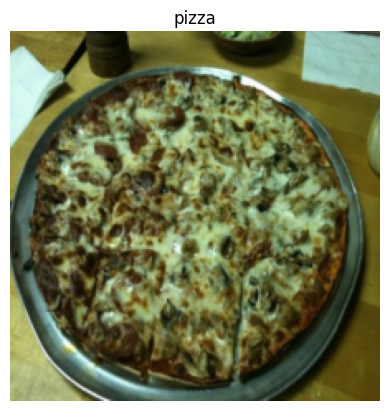

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)


torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [477, 19, 316, 701, 80]


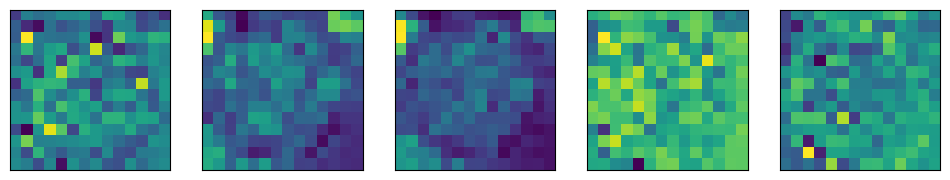

In [19]:
# plot random convolutional feature maps (embeddings)
import random

random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension and remove from grad tracking/switch to numpy for matplotlib
  ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.3570, -0.3396, -0.3354, -0.1437,  0.0425, -0.3132, -0.3362,
           -0.3130, -0.2258, -0.2427, -0.1588, -0.4496, -0.5180, -0.3744],
          [-0.6862, -0.4881, -0.2470, -0.2316, -0.0170, -0.2375, -0.2144,
           -0.3623, -0.5352, -0.1882, -0.1918, -0.4762, -0.5524, -0.5229],
          [-0.7194, -0.7620, -0.2157, -0.3133, -0.1080, -0.2905, -0.3946,
           -0.3795, -0.4061, -0.1912, -0.3919, -0.2634, -0.3168, -0.3895],
          [-0.7547, -0.3521, -0.2921, -0.2214, -0.5797, -0.5811, -0.0969,
           -0.2367, -0.2896, -0.3542, -0.4355, -0.3641, -0.2487, -0.2068],
          [-0.4296, -0.2583, -0.2998, -0.4223, -0.6117, -0.4684, -0.4138,
           -0.4440, -0.2268, -0.3170, -0.2614, -0.2469, -0.2402, -0.1703],
          [-0.4804, -0.3427, -0.5758, -0.3635, -0.3602, -0.1780, -0.3424,
           -0.4307, -0.4538, -0.3966, -0.4150, -0.3225, -0.3192, -0.2435],
          [-0.2190, -0.2086, -0.4318, -0.5250, -0.2048, -0.4176, -0.3967,
           -0.4270, -0.2612, -0.

#### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Rigth now we've got a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [21]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [22]:
from torch import nn

flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Orginal image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


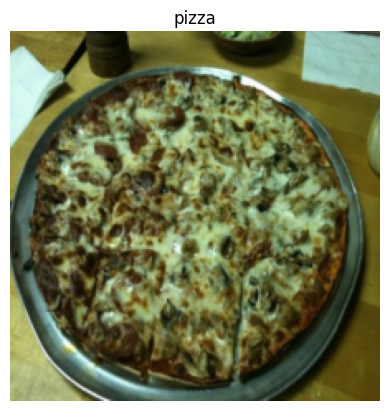

In [23]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Orginal image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


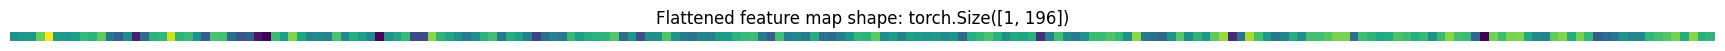

In [25]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in step 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.


In [26]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  #2 Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768): # from Table 1 for ViT-Base

    super().__init__()

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2, # height dimension
                              end_dim=3) # width dimension

    self.patch_size = patch_size


  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'

    # Perform the forward pass
    x_flattened = self.flatten(self.patcher(x))

    # 6.  Make sure the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)


In [27]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # Add a batch dimension

print(f"Outpur patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Outpur patch embedding sequence shape: torch.Size([1, 196, 768])


In [28]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)
#patchify(rand_image_tensor_bad)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [29]:
patch_embedded_image

tensor([[[-0.3261,  0.2616, -0.5382,  ...,  0.4652, -0.1906,  0.1589],
         [-0.4848,  0.0720, -0.0914,  ...,  0.3237, -0.2651,  0.1831],
         [-0.4878, -0.0067, -0.1063,  ...,  0.1999, -0.0468,  0.2487],
         ...,
         [-0.3643,  0.0765, -0.1060,  ...,  0.2660, -0.1016,  0.0417],
         [-0.3097,  0.0358, -0.1106,  ...,  0.2063, -0.1692,  0.1796],
         [-0.2950,  0.0277, -0.0876,  ...,  0.1780, -0.1444,  0.1344]]],
       grad_fn=<PermuteBackward0>)

In [30]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [31]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [32]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3261,  0.2616, -0.5382,  ...,  0.4652, -0.1906,  0.1589],
         [-0.4848,  0.0720, -0.0914,  ...,  0.3237, -0.2651,  0.1831],
         ...,
         [-0.3643,  0.0765, -0.1060,  ...,  0.2660, -0.1016,  0.0417],
         [-0.3097,  0.0358, -0.1106,  ...,  0.2063, -0.1692,  0.1796],
         [-0.2950,  0.0277, -0.0876,  ...,  0.1780, -0.1444,  0.1344]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the posistion embedding

Want to: create a series of 1D learnable position embeddings and to add them to sequence of patch embeddings.

In [34]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) /  patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension,
                                             requires_grad=True))

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [35]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6739, 1.2616, 0.4618,  ..., 1.4652, 0.8094, 1.1589],
         [0.5152, 1.0720, 0.9086,  ..., 1.3237, 0.7349, 1.1831],
         ...,
         [0.6357, 1.0765, 0.8940,  ..., 1.2660, 0.8984, 1.0417],
         [0.6903, 1.0358, 0.8894,  ..., 1.2063, 0.8308, 1.1796],
         [0.7050, 1.0277, 0.9124,  ..., 1.1780, 0.8556, 1.1344]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's see it all in one cell.

In [36]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print the shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [56]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  #2 Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768): # from Table 1 for ViT-Base

    super().__init__()

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2, # height dimension
                              end_dim=3) # width dimension

    self.patch_size = patch_size
    self.embedding_dim = embedding_dim


  # 7. Create a class token embedding
  def add_class_token(self, x):
    self.batch_size = x.shape[0]
    class_token = nn.Parameter(torch.rand(self.batch_size, 1, self.embedding_dim),
                              requires_grad=True)

    # 8. Prepend the class token embedding to the patch embedding
    return torch.cat((class_token, patch_embedding), dim=1)


  # 9. Create position embedding
  def add_position_embedding(self, x, height, width):
    number_of_patches = int((height*width) / self.patch_size**2)

    position_embedding = nn.Parameter(torch.rand(1, number_of_patches + 1, self.embedding_dim),
                                      requires_grad=True)

    # 10. Add the position embedding to patch embedding with class token
    return x + position_embedding


  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'

    # Perform the forward pass
    # 6.  Make sure the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    x_flattened = self.flatten(self.patcher(x))
    x_flattened = x_flattened.permute(0, 2, 1)

    class_token = self.add_class_token(x_flattened)

    return self.add_position_embedding(self.add_class_token(x_flattened), x.shape[-1], x.shape[-1])


In [38]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # Add a batch dimension

print(f"Outpur patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Outpur patch embedding sequence shape: torch.Size([1, 197, 768])


In [39]:
patch_embedded_image

tensor([[[ 0.7203,  1.4680,  0.7940,  ...,  1.2281,  0.4268,  0.3012],
         [ 0.0672,  0.4993,  0.0905,  ...,  1.0548,  0.5271,  1.0300],
         [ 0.2418,  0.4929,  0.6834,  ...,  0.5863, -0.2273,  0.5967],
         ...,
         [ 0.2023,  0.4613,  0.3709,  ...,  0.8608,  0.2018,  0.4616],
         [-0.1347,  0.1946,  0.3283,  ...,  1.1025, -0.1188,  0.5040],
         [-0.1670,  0.0669,  0.6359,  ...,  0.9942,  0.1383,  0.6726]]],
       grad_fn=<AddBackward0>)

### Equation 2: Multihead Self-Attention (MSA block)

* Multihead self-attention: which part of a sequence should pay the most attention to self?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicated MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers.  It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard diviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values of $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
  * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [40]:
class MultiHeadSelfAttentionBlock(nn.Module):

  """Creates a multi-head self-attention block ("MSA block" for short).
  """
  def __init__(self,
                embedding_dim:int=768, #Hidden size D (embedding dimension) from Tabel 1 for ViT-Base
                num_heads:int=12, # Heads from Tabel 1 for ViT-Base
                attn_dropout: int=0):

      super().__init__()
      # Create the norm layer (LN)
      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

      # Create multihead self attention (MSA) layer
      self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  dropout=attn_dropout,
                                                  batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)


  def forward(self, x):
    x = self.layer_norm(x)
    attn_outputs, _ = self.multihead_attn(query = x,
                                         key = x,
                                         value = x,
                                         need_weights = False)
    return attn_outputs

In [41]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_embedded_image)
print(f"Input shape of MSA block: {patch_embedded_image.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP) block

* **MLP** = The MLP contains two layers with a GELU non-linearity. (section 3.1).
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing.  In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GELU in PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * MLP number of hidden units = MLP Size in Table 1
* **Dropout** = Dropout, when used, is applied after every dense layer except for the qkv-projections and directly after adding positional - to patch embeddings.  Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3

  In pseudocode:

  ```python
  # MLP
  x = linear -> non-linear -> dropout -> linear -> dropout
  ```

In [42]:
class MLPBlock(nn.Module):
  """Creates a multi-layer perceptron block ("MLP block" for short).
  """
  def __init__(self,
               embedding_dim: int=768,
               mlp_size: int=3072,
               dropout:int=0.1):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )


  def forward(self, x):
    return self.mlp(self.layer_norm(x))


In [43]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of the MSA Block through MLP Block
patached_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patached_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Create the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learned representation back to some sort of sequence
* Residual connections = add a layer(s) input its subsequent output, this enables the creation of deeper networkds (prevents weights from getting too small)

In pseudocode:
```python
# Transformer Encoder
x_input = -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transformer Encoder Block

In [44]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int= 768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads: int = 12, # from table 1
               mlp_size:int = 3072, # from table 1
               mlp_dropout:int= 0.1, # from table 3
               attn_dropout:int= 0):

    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)


  def forward(self, x):
    x = self.msa_block(x) + x #residual/skip connection for equation 2
    x = self.mlp_block(x) + x #residual/skip connection for equation 3
    return x

In [45]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimenstion)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transformer Encoder layer with pure PyTorch layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer

In [46]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from Table 1
                                                             nhead=12, # heads from Table 1
                                                             dim_feedforward=3072, # MLP size from Table 1
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True, # batch dimension is first
                                                             norm_first=True) # Normalization is first

torch_transformer_encoder_layer


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [47]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimenstion)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time recreating the transformer encoder when we could've just made it with a single PyTorch layer?

Practice. Practice. Practice.

Now we know how things are implemented behind the scenes, we can tweek them if necessary.

What are the benefits of using a pre-built PyTorch layer?

* Less prone to errors (goes through a bunch of tesing)
* Potential benefit fo speed ups (Performance Boosts)

## 8. Putting it all together to creaet ViT

In [125]:
# Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    # Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768,
                 embedding_dropout:int=0.1):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.patch_size = patch_size

        # Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create a class token embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

    # Create position embedding
    def add_position_embedding(self, x: torch.Tensor, height: int, width: int) -> torch.Tensor:
      number_of_patches = int((height*width) / self.patch_size**2)

      position_embedding = nn.Parameter(data=torch.randn(1, number_of_patches+1, self.embedding_dim),
                                               requires_grad=True)

      # Add the position embedding to patch embedding with class token
      return x.to(device) + position_embedding.to(device)

    # Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Get batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Perform the forward pass
        # Make sure the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
        x = self.flatten(self.patcher(x))
        x = x.permute(0, 2, 1)

        # Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding (equation 1)
        x = self.add_position_embedding(x,image_resolution, image_resolution)

        # Run embedding dropout (Appendix B.1)
        return self.embedding_dropout(x).to(device)

In [128]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size: int=224, # Table 3 fromr ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
    super().__init__()

    # Create patch embedding layer
    self.patch_embedding  = PatchEmbedding(in_channels=in_channels,
                            patch_size=patch_size,
                            embedding_dim=embedding_dim,
                            embedding_dropout=embedding_dropout).to(device)

    # Create the Trasnformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]).to(device)

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes).to(device)
    ).to(device)

  def forward(self, x):

    # Creaet the patch embedding (equation 1)
    x = self.patch_embedding(x).to(device)

    # Pass position and patch embedding to Transformer encoder (equation 2 & 3)
    x = self.transformer_encoder(x).to(device)

    # Put 0th index logit through classifier (equation 4)
    return self.classifier(x[:, 0]).to(device)


In [129]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224).to(device) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.1276,  0.8833, -0.4093]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [132]:
from torchinfo import summary


# Get a summary using torchinfo.summary
summary(model=ViT(num_classes=len(class_names)).to(device),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               --                   True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 197, 768]        768                  True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
│    └─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

### 9. Setting up training code for our custom ViT

We've replicated the ViT architecture, now let's see how it performs on our FoodVision Mini data.

## 9.1 Creating an optimizer

The paper states it used the Adam optimizer (section 4, Training & Fine Tuning)
with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularizatin technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.  loss = loss + weight decay parameter * L2 norm of the wieghts.

Regularization technique = prevents overfitting

In [135]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`

In [136]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [137]:
from going_modular.going_modular import engine

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.5037 | train_acc: 0.2148 | test_loss: 1.1722 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.7800 | train_acc: 0.3164 | test_loss: 1.5508 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.2882 | train_acc: 0.3906 | test_loss: 1.7176 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2199 | train_acc: 0.4141 | test_loss: 0.9145 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1731 | train_acc: 0.2852 | test_loss: 1.1122 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.2607 | train_acc: 0.3906 | test_loss: 1.8689 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.4466 | train_acc: 0.4180 | test_loss: 1.4023 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.2747 | train_acc: 0.4531 | test_loss: 1.8990 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2633 | train_acc: 0.4102 | test_loss: 2.2321 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.3526 | train_acc: 0.3984 | test_loss: 1.6045 | test_acc: 0.1979


In [ ]:
### 9.4 What our training setup is missing

How is our training setup different to the ViT paper?

We've repllicated the model architecture correctly.

But what